## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

## Read in the raw data file

In [2]:
def get_data(p): # p = proportion of dataset to keep
    # Path which our data is stored
    path = 'dns_oct-jan.csv'

    data = pd.read_csv(
             path,
             header=0, 
             skiprows=lambda i: i>0 and random.random() > p
    )

    # Change to data type to datetime
    data['day'] = pd.to_datetime(data.day)

    # Keep necessary columns
    data = data[['shieldid', 'day', 'dns_qname', 'dns_qdomainname', 'num_clients', 'num_responses']]
    
    return data

## We have the following columns in "data":

- index
- shieldid
- day
- dns_qname
- dns_qdomainname
- num_clients
- num_responses

In [3]:
data = get_data(1)
data.head()

,shieldid,day,dns_qname,dns_qdomainname,num_clients,num_responses
0,ajkerabo,2022-11-01,104422-22.chat.api.drift.com,drift.com,1,8
1,ajkerabo,2022-12-31,11.au.download.windowsupdate.com,windowsupdate.com,1,2
2,ajkerabo,2022-10-07,569c0a1f72747e0eb7ce1c550cb03bbc.fp.measure.of...,office.com,1,12
3,ajkerabo,2022-11-02,aadcdn.msftauth.net,msftauth.net,2,3
4,ajkerabo,2022-10-31,accounts.platform.intuit.com,intuit.com,1,16


In [4]:
def get_df(data):    
    
    # df1 sums by domain name and day
    df1 = data.groupby(by=['dns_qdomainname','day']).sum()

    # df2 counts unique query names by domain name and day
    df2 = data.groupby(by=['dns_qdomainname','day'])[['dns_qname','shieldid']].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname', 'shieldid': 'num_shieldid'}, inplace=True)
    
    # Concatenate df1 and df2 into df
    df = pd.concat([df1, df2], axis=1)
    df.reset_index(level=1, inplace=True)
    
    # Domains that exist in the data more than 1 day
    two_plus_days = list(df.groupby(by=df.index)['day'].nunique().loc[df.groupby(by=df.index)['day'].nunique()>1].index)

    # Domains that exist in the data with at least 5 clients
    five_plus_clients = list(df.groupby(by=df.index).num_clients.sum().loc[df.groupby(by=df.index).num_clients.sum()>=5].index)

    # Domains that exist in the data with at least 10 responses
    ten_plus_responses = list(df.groupby(by=df.index).num_responses.sum().loc[df.groupby(by=df.index).num_responses.sum()>=10].index)

    # Keep rows in which the domain satisfies at least of the above requirements
    df = df.loc[(df.index.isin(two_plus_days))|(df.index.isin(five_plus_clients))|(df.index.isin(ten_plus_responses))]

    return df

## We have the following columns in "df":

- index
- day
- num_clients
- num_responses
- num_dns_qname
- num_shieldid

In [5]:
df = get_df(data)
df

,day,num_clients,num_responses,num_dns_qname,num_shieldid
dns_qdomainname,,,,,
*google.com,2022-10-02,1,2,1,1
*google.com,2022-10-03,1,2,1,1
*google.com,2022-10-04,1,2,1,1
*google.com,2022-10-10,1,1,1,1
*google.com,2022-10-11,3,115,1,2
...,...,...,...,...,...
zzztube.com,2023-01-23,2,32,1,1
zzzzz.jp,2023-01-19,2,2,1,1
zzzzz.jp,2023-01-20,2,3,1,1


In [6]:
df.index.nunique()

778253

# Building a model

In [7]:
# Import libraries for our anomaly detection model
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [8]:
def get_df_train(df, k):
    
    # Create a df_train data frame
    df_train = df.copy()

    # Randomly sample k domains
    domain_train = list(random.sample(list(df_train.index.unique()), k))
    df_train = df_train.loc[df_train.index.isin(domain_train)]

    from itertools import product
    
    # Create lists of all unique values in columns 
    l1 = list(df_train.index.unique())
    l2 = list(data.day.unique())
    l3 = [0]
    l4 = [0]
    l5 = [0]
    l6 = [0]
    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'num_clients', 'num_responses', 'num_dns_qname', 'num_shieldid'])
    _.set_index(list(_)[0], inplace=True)

    df_train = pd.concat([df_train, _])

    df_train = df_train.groupby(by=[df_train.index,df_train.day]).sum()
    df_train.reset_index(level=1, inplace=True)
    df_train = df_train.sort_values(['dns_qdomainname','day'])
    
    # Domain number of clients divided by domain number of clients sum
    df_train['stnorm_num_clients'] = df_train.groupby('dns_qdomainname')['num_clients'].transform(lambda x: (x-x.mean())/x.std())
    
    # Domain number of responses divided by domain number of responses sum
    df_train['stnorm_num_responses'] = df_train.groupby('dns_qdomainname')['num_responses'].transform(lambda x: (x-x.mean())/x.std())
    
    df_train.fillna(0, inplace=True)
    
    # Create a day of week column
    df_train['day_of_week'] = df_train.day.dt.dayofweek
    
    return df_train

### The function get_df_train transforms k domains into our desired feature matrix.

## We have the following columns in "df_train":

- dns_qdomainname
- day
- num_clients
- num_responses
- num_dns_qname
- num_shieldid
- stnorm_num_clients
- stnorm_num_responses
- day_of_week

In [9]:
df_train = (get_df_train(df, 1000))
df_train.head()

,day,num_clients,num_responses,num_dns_qname,num_shieldid,stnorm_num_clients,stnorm_num_responses,day_of_week
dns_qdomainname,,,,,,,,
0310com.com,2022-10-01,0,0,0,0,-0.162234,-0.15273,5
0310com.com,2022-10-02,0,0,0,0,-0.162234,-0.15273,6
0310com.com,2022-10-03,0,0,0,0,-0.162234,-0.15273,0
0310com.com,2022-10-04,0,0,0,0,-0.162234,-0.15273,1
0310com.com,2022-10-05,0,0,0,0,-0.162234,-0.15273,2


In [40]:
pd.save_as()

,day,num_clients,num_responses,num_dns_qname,num_shieldid
dns_qdomainname,,,,,
*google.com,2022-10-02,1,2,1,1
*google.com,2022-10-03,1,2,1,1
*google.com,2022-10-04,1,2,1,1
*google.com,2022-10-10,1,1,1,1
*google.com,2022-10-11,3,115,1,2
...,...,...,...,...,...
zzztube.com,2023-01-23,2,32,1,1
zzzzz.jp,2023-01-19,2,2,1,1
zzzzz.jp,2023-01-20,2,3,1,1


## Pipeline

In [10]:
# Define numerical and categorical features
num_features = ['num_shieldid', 'stnorm_num_clients', 'stnorm_num_responses']
cat_features = ['day_of_week']

# Process numeric data
num_processor = Pipeline(steps=[
    ('scaler', MinMaxScaler())
    ])

# Process categorical data
cat_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))
])

# Process all the features
features_processor = ColumnTransformer(
    transformers=[
        ('numerical processor', num_processor, num_features),
        ('categorical processor', cat_processor, cat_features),
    ],
        remainder='drop')

# Initialize the Isolation Forest model
clf = IsolationForest(n_estimators=1000, max_samples=116000, contamination=float(.0001), max_features=1.0)

# Define our pipeline
pipe = Pipeline(steps=[
    ('feature_processor', features_processor),
    ('classifier', clf)
])

pipe

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('numerical processor',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['num_shieldid',
                                                   'stnorm_num_clients',
                                                   'stnorm_num_responses']),
                                                 ('categorical processor',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['day_of_week'])])),
                ('classifier',
                 IsolationForest(contamination=0.0001, max_samples=116000,
                                 n_estimators=1000))])

## Fit df_train to the model

In [11]:
# Fit the dataset to the model
pipe.fit(df_train)

# Predict anomalies in the dataset
preds = pipe.predict(df_train)

# Create a column of the predictions
df_train['pred'] = preds

# Dataset with all outlier instances
outliers = df_train.loc[df_train.pred==-1]
    
# List of domain outliers
domain_outliers = list(outliers.index.unique())

## Show the domain outliers

In [12]:
domain_outliers

['awsdns-43.net',
 'bartzviviano.com',
 'fighterjetsworld.com',
 'isappcloud.com',
 'jessicaheronimages.com',
 'liquidtelecom.com',
 'notion.so',
 'pulpbits.net',
 'weather.gov',
 'yesoulfitness.com']

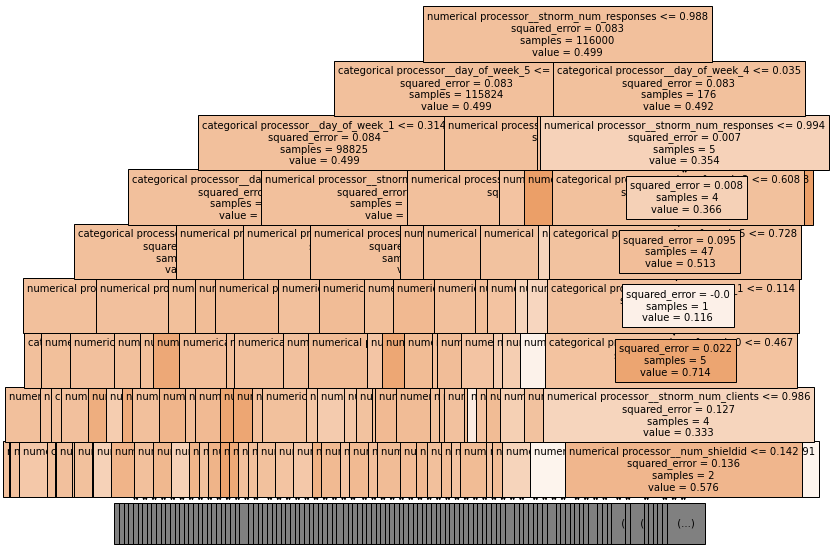

In [13]:
from sklearn.tree import plot_tree

labels = list(features_processor.fit(df_train).get_feature_names_out())
# Plot the first tree in the forest
plt.figure(figsize=(10, 10))
plot_tree(clf.estimators_[1], max_depth=8, filled=True, feature_names=labels, fontsize=10)
plt.show()

## Looking at a specific domain that was marked as an outlier

In [43]:
# A specific domain outlier
domain_name = random.sample(domain_outliers,1)[0]

# A dataframe with all instances of the outlier domain
domain_case = get_df_train(get_df(data.loc[data.dns_qdomainname==domain_name]), 1)

domain_case.head()

,day,num_clients,num_responses,num_dns_qname,num_shieldid,stnorm_num_clients,stnorm_num_responses,day_of_week
dns_qdomainname,,,,,,,,
jessicaheronimages.com,2022-10-01,0,0,0,0,-0.092848,-0.092848,5
jessicaheronimages.com,2022-10-02,0,0,0,0,-0.092848,-0.092848,6
jessicaheronimages.com,2022-10-03,0,0,0,0,-0.092848,-0.092848,0
jessicaheronimages.com,2022-10-04,0,0,0,0,-0.092848,-0.092848,1
jessicaheronimages.com,2022-10-05,0,0,0,0,-0.092848,-0.092848,2


In [44]:
def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new
domain_case_new = get_domain_case_new(data, domain_name)

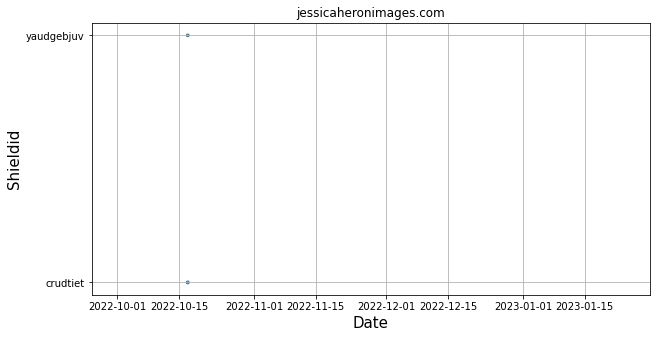

In [45]:
# Plot
plt.figure(figsize=(10,5))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)
plt.title(domain_name)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')

Text(0, 0.5, 'Number of Shield Ids')

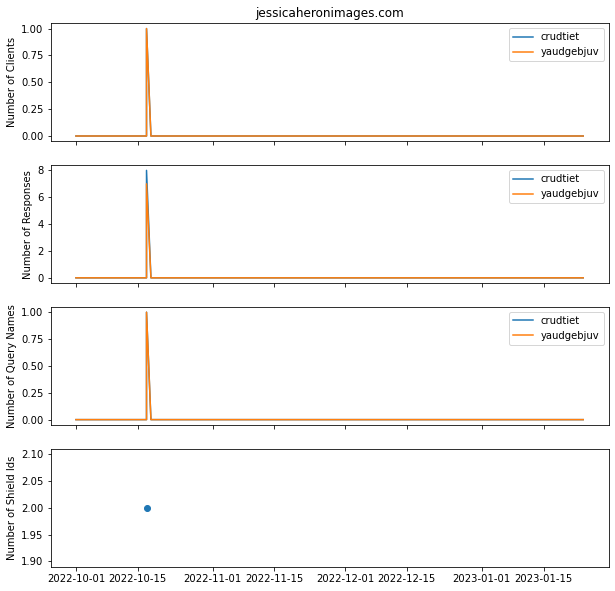

In [46]:
fig, ax = plt.subplots(4,1, sharex=True, figsize=(10,10))

for i in range(domain_case_new.shieldid.nunique()):
    a = list(domain_case_new.shieldid.unique())[i]
    
    ax[0].set_title(domain_name)
    
    ax[0].plot(domain_case_new[domain_case_new.shieldid==a].day, domain_case_new[domain_case_new.shieldid==a].num_clients, label=a)
    ax[0].legend()
    ax[0].set_ylabel('Number of Clients')
    
    ax[1].plot(domain_case_new[domain_case_new.shieldid==a].day, domain_case_new[domain_case_new.shieldid==a].num_responses, label=a)
    ax[1].legend()
    ax[1].set_ylabel('Number of Responses')
    
    ax[2].plot(domain_case_new[domain_case_new.shieldid==a].day, domain_case_new[domain_case_new.shieldid==a].num_dns_qname, label=a)
    ax[2].legend()
    ax[2].set_ylabel('Number of Query Names')
    
ax[3].scatter(domain_case_new.loc[domain_case_new.num_clients>0].groupby('day').shieldid.nunique().index, domain_case_new.loc[domain_case_new.num_clients>0].groupby('day').shieldid.nunique())
ax[3].set_ylabel('Number of Shield Ids')   

Tranco
Quantcast
Majestic

In [77]:
path = 'https://raw.githubusercontent.com/zer0h/top-1000000-domains/master/top-1000000-domains'
top_domains = pd.read_csv(path, header=None)

In [79]:
top_domains.rename({0: 'dns_qdomainname'}, axis=1, inplace=True)
rank = list(range(1, 1_000_001).as_type(int))
top_domains['rank'] = rank
top_domains.set_index('dns_qdomainname',inplace=True)

In [86]:
df.head(1)

,day,num_clients,num_responses,num_dns_qname,num_shieldid
dns_qdomainname,,,,,
*google.com,2022-10-02,1,2,1,1


In [91]:
top_domains.head(1)

,rank
dns_qdomainname,
google.com,1


In [99]:
df.merge(top_domains, how='left', left_on='dns_qdomainname', right_on='dns_qdomainname')

,day,num_clients,num_responses,num_dns_qname,num_shieldid,rank
dns_qdomainname,,,,,,
*google.com,2022-10-02,1,2,1,1,NaN
*google.com,2022-10-03,1,2,1,1,NaN
*google.com,2022-10-04,1,2,1,1,NaN
*google.com,2022-10-10,1,1,1,1,NaN
*google.com,2022-10-11,3,115,1,2,NaN
...,...,...,...,...,...,...
zzztube.com,2023-01-23,2,32,1,1,113033.0
zzzzz.jp,2023-01-19,2,2,1,1,NaN
zzzzz.jp,2023-01-20,2,3,1,1,NaN
